In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import math


# Part 1

## Insurance dataset
I chose this dataset since I work for a benefit offering company and I'm interested in understanding more on how the insurance market works.






In [287]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [288]:
df.shape
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Hypothesis
1. Older people would have higher charges than younger people since younger people tend to have healthier bodies.
2. A high BMI would have higher charges as they are more prone to diseases.
3. The number of children should be positively correlated to charges since this would mean more number of dependents.
4. A smoker would have higher charges than a non smoker.
5. The sex of the member shoudn't matter.

## Target Variable
The dataset has various predictor variables that will help us predict the insurance charges. Therefore, our target variable is "charges".

In [289]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Observation

1. The summary stats tell us that mean charges is 13,270 with a high standard deviation of 12,110.
2. The mean of children is 1 meaning we have members with usually 1 child.
3. The average age is 39 for a member.

In [290]:
missing_values_count = df.isna().sum()
missing_values_count

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Observation

We see no missing values in the columns which is good news!!

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

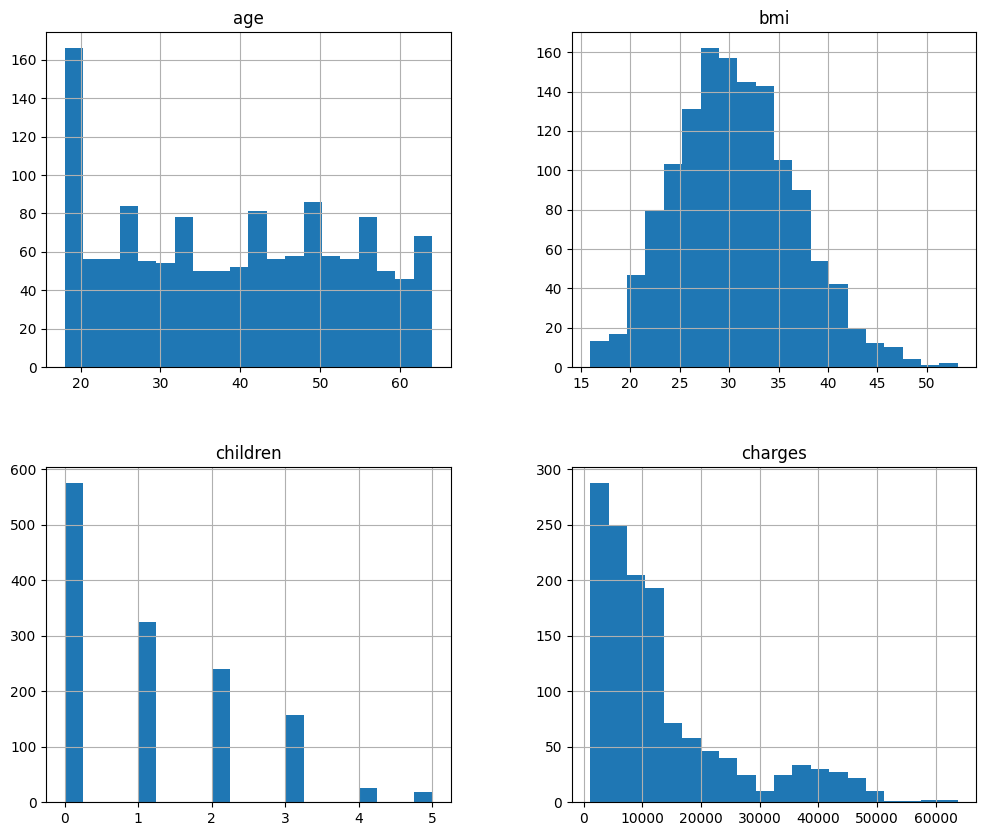

In [291]:
%matplotlib inline
df.hist(bins=20, figsize=(12, 10))


## Observation
1. We see that age distribution is the most spread out of all.
2. BMI somewhat follows a normal distribution.
3. Children column is a discrete numerical variable.
4. Less amount of charges is more frequent than high amount of charges.


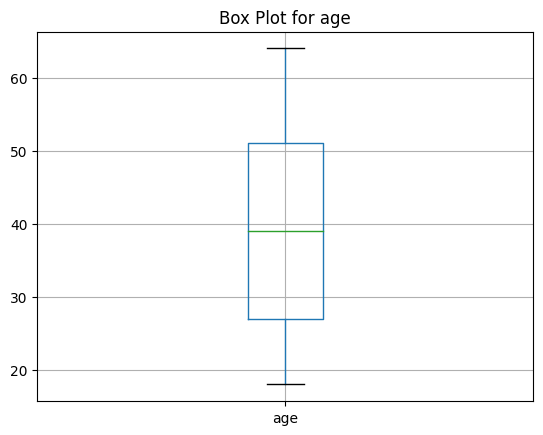

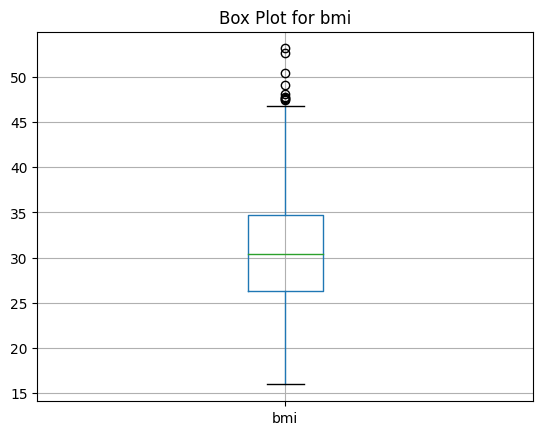

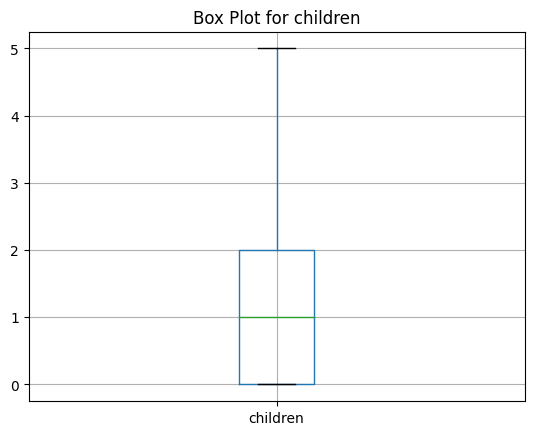

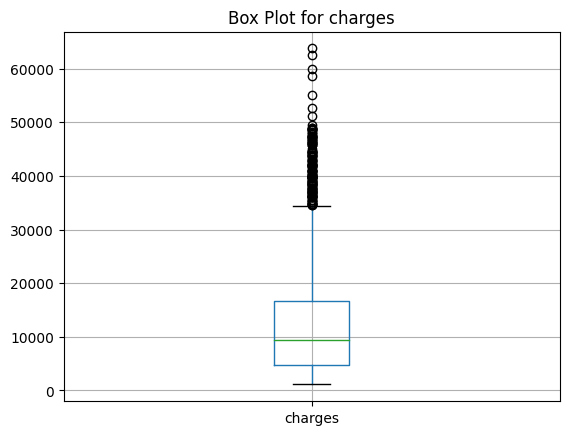

In [292]:
numeric_columns = df.select_dtypes(include=['number']).columns

for column in numeric_columns:
    df.boxplot(column=column)
    plt.title(f'Box Plot for {column}')
    plt.show()

## Observation

1. We see charges has a long upper tail with outliers.
2. BMI has outliers too but comparatively shorter upper tail.
3. Children and age have similar amount of variations.
4. Bmi and charges have similar amount of variations.

## Outlier removal

In [293]:
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]


for i, column in enumerate(numeric_columns):
    df[column] = remove_outliers(df[column])



## Boxplot of Smoker vs Non Smoker

Lets check out how smokers are charged vs non smokers.

<Axes: xlabel='smoker', ylabel='charges'>

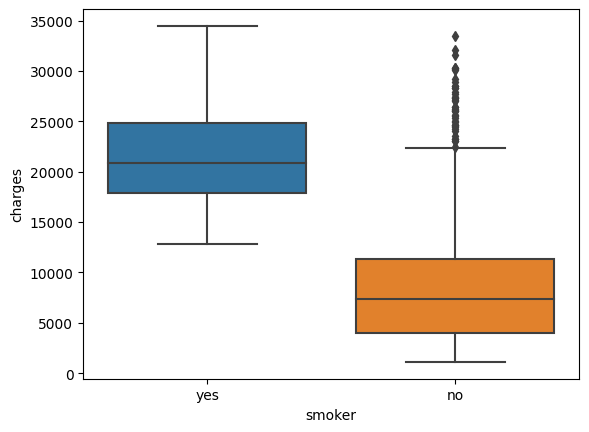

In [294]:
sns.boxplot(x='smoker', y='charges', data=df)

## Observation

1. Smokers are charged more than smokers. Hence, our hypothesis stands correct.
2. They both have similar amounts of varation.

## Boxplot of Male vs Female

<Axes: xlabel='sex', ylabel='charges'>

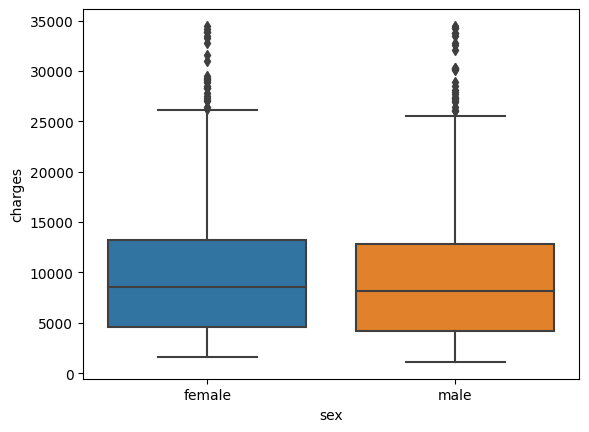

In [295]:
sns.boxplot(x='sex', y='charges', data=df)

## Observation

We do not see a significant difference in charges for male vs female. Therefore, our hypothesis stands corrected.

## Pairplot

Let us create a matrix of pairplot to observe any correlations.

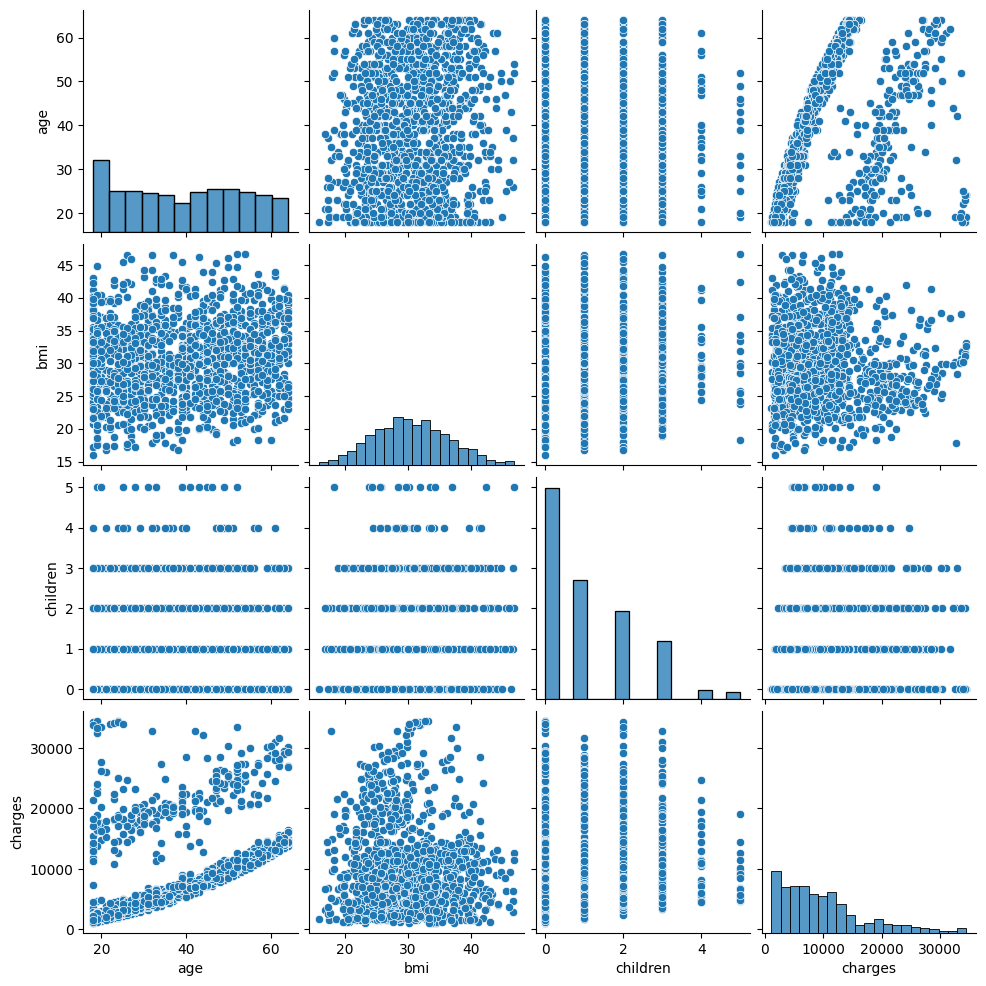

In [296]:
sns.pairplot(df[numeric_columns])

## Observation

1. We can see some positive correlation of charges with age.
2. Based on our assumption earlier, we fail to see any correlation between bmi and charges.
3. Children is a discrete variable and hence doesn't show any meaningful insights here.

## Pearson Correlations Matrix
Let's create compute a matrix of Pearson correlations to look at the coefficient of correlations.

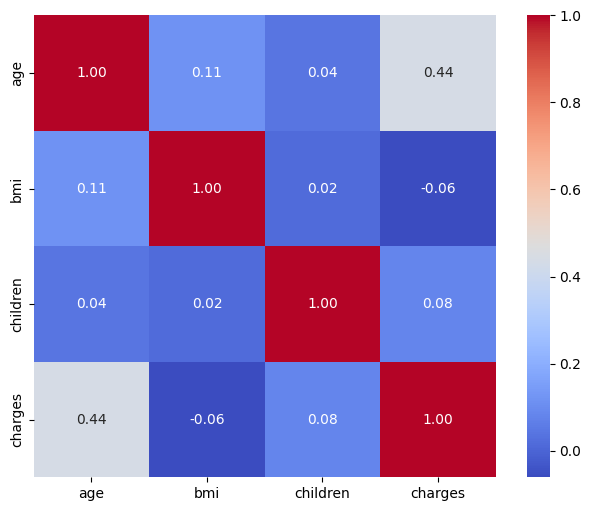

In [297]:
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.show()

## Refined Hypothesis

1. There is a significant positive correlation between age and charges.
2. There is a weak positive correlation between children and charges and bmi and age.
3. There is no significant correlation between bmi and charges.
4. Smokers would have higher charges than non smokers.
5. The charges have no relation to the sex of the member.


## EDA Conclusions

1. Age would be a very good predictor for the charges.
2. Children should have some impact in predicting the charges.
3. Smoker column would have some impact on the charges.


# Part 2

We will apply regression on this dataset to predict the charges of insurance.

## Analysis to either normalize or standardize

Let's check the distribution of the columns by drawing histograms and kernel densities of the columns. We will drop the target variable since the distribution of the target variable will not affect our decision to standardize/normalize





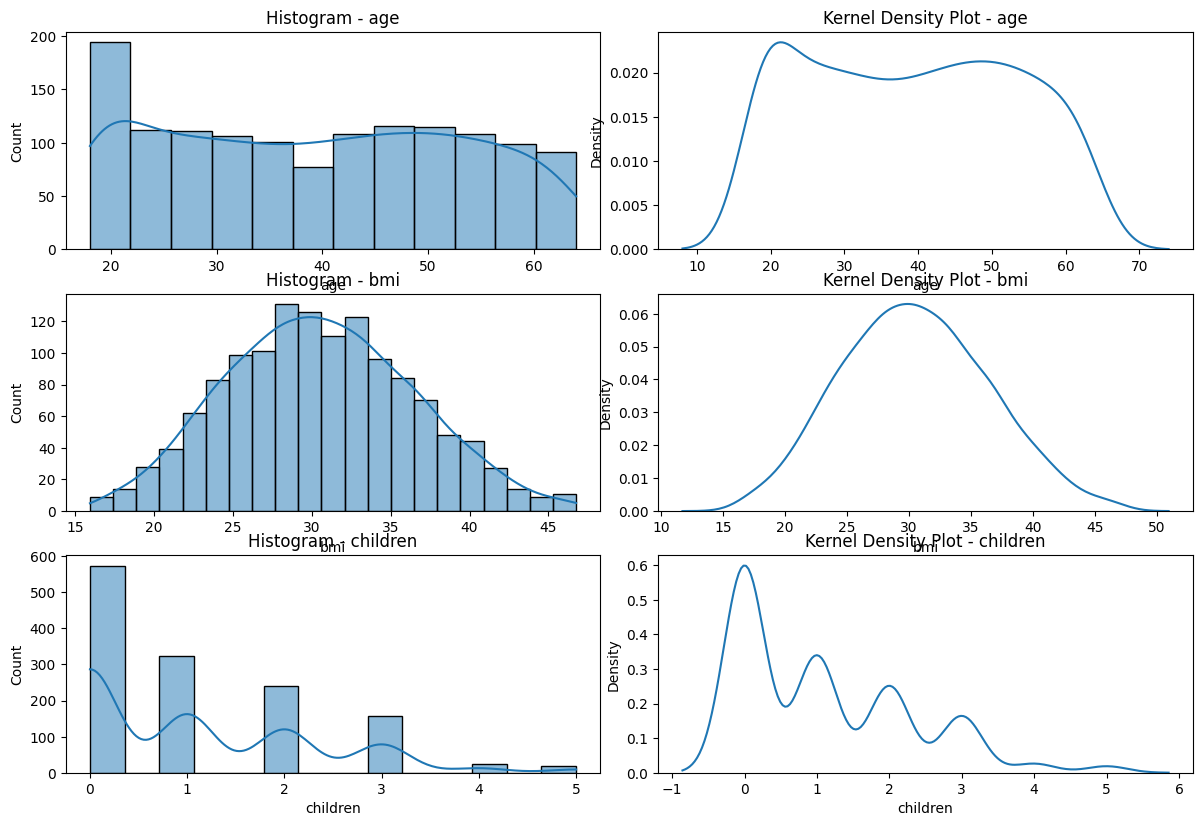

In [298]:
# Dropping the target variable
numeric_columns = numeric_columns[:-1]

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(12, 8))
fig.tight_layout()

# Loop through numerical columns and create distribution plots
for i, column in enumerate(numeric_columns):
    # Histogram
    sns.histplot(df[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram - {column}')

    # Kernel Density Plot
    sns.kdeplot(df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Kernel Density Plot - {column}')

plt.show()

## Observation

We can see that the predictor variables Age and Children do not follow a guassian distribution whereas BMI predictor variable does. Standardization is recommended when we do know the distribution of the predictor variables is guassian. Here, we know that BMI is the only one that follows a guassian distribution and hence, standardization might not be as effective.

Let's check the box plots again to see if there are outlier still present in our dataset

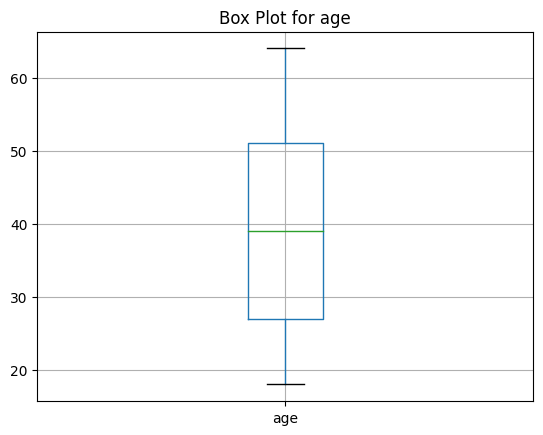

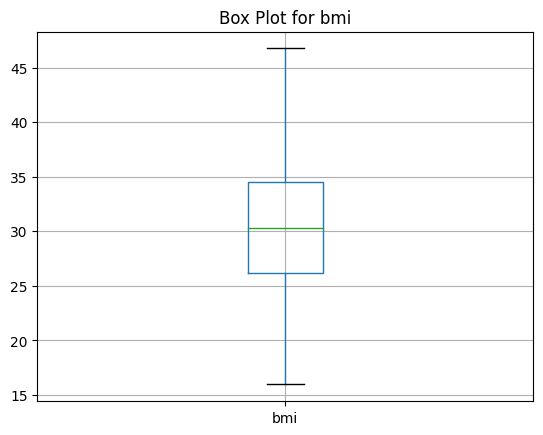

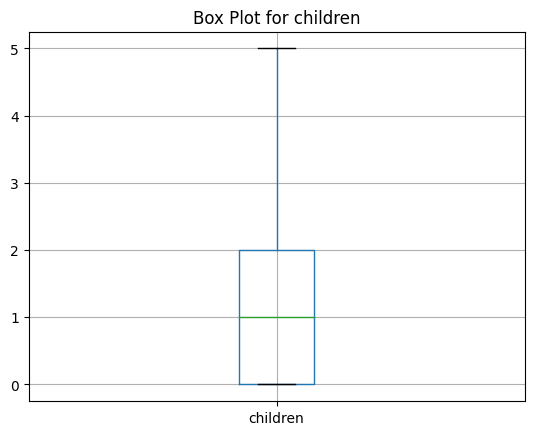

In [299]:
for column in numeric_columns:
   df.boxplot(column=column)
   plt.title(f'Box Plot for {column}')
   plt.show()

## Observation

We can see there are no outliers present in the predictor variables. Age and BMI have a slightly different scale whereas children has a much smaller scale. Hence, normalization will be an effective technique here to get better results.

## Normalizing the Data

We will use MinMaxScaler to normalize the predictor variables.

In [300]:

# Extract the numeric columns from the data
X_numeric = df[numeric_columns]


scaler = MinMaxScaler()
X_numeric_normalized = scaler.fit_transform(X_numeric)

# DataFrame for the normalized numeric columns
normalized_numeric_df = pd.DataFrame(X_numeric_normalized, columns=numeric_columns)

# Concatenate the normalized numeric columns with the remaining columns
normalized_df = pd.concat([normalized_numeric_df, df.drop(numeric_columns, axis=1)], axis=1)

normalized_df.head()


,age,bmi,children,sex,smoker,region,charges
0,0.021739,0.387788,0.0,female,yes,southwest,16884.92400
1,0.000000,0.578435,0.2,male,no,southeast,1725.55230
2,0.217391,0.553426,0.6,male,no,southeast,4449.46200
3,0.326087,0.219065,0.0,male,no,northwest,21984.47061
4,0.304348,0.419617,0.0,male,no,northwest,3866.85520


## Linear Regression on Normalized Data

We will use the normalized features along with the 'smoker' feature to perform linear regression. We will only use smoker variable from categorical variables as we saw from the box plots that 'sex' and 'region' do not have a significant difference in mean/variation with respect to 'charges'.

In [301]:
# Using only smoker column
categorical_column = ['smoker']

# OneHot encoding
encoded_categorical = pd.get_dummies(normalized_df[categorical_column], drop_first=True)
normalized_df_encoded = pd.concat([normalized_df, encoded_categorical], axis=1)
normalized_df_encoded = normalized_df_encoded.dropna()
normalized_df_encoded = normalized_df_encoded.drop(['sex', 'region'] + categorical_column, axis=1)  # Drop 'sex' and 'region'

# Print encoded df
normalized_df_encoded.head()

,age,bmi,children,charges,smoker_yes
0,0.021739,0.387788,0.0,16884.92400,1
1,0.000000,0.578435,0.2,1725.55230,0
2,0.217391,0.553426,0.6,4449.46200,0
3,0.326087,0.219065,0.0,21984.47061,0
4,0.304348,0.419617,0.0,3866.85520,0


In [302]:
X = normalized_df_encoded.drop('charges', axis=1)
y = normalized_df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients of the model
coefficients_df = pd.DataFrame({'Predictor': X_train.columns, 'Coefficient': model.coef_})
print('\nCoefficients:')
print(coefficients_df)

# Intercept of the model
print(f'\nIntercept: {model.intercept_}')



Coefficients:
    Predictor   Coefficient
0         age  11230.845813
1         bmi   1688.618451
2    children   2160.776740
3  smoker_yes  15504.663378

Intercept: 1852.3972255233093


## Interpretation

1. Smoker_yes has the highest effect on predicting the charges of the model and is positively correlated to the charges
2. Age has the second highest effect and is also positively correlated.
3. When smoker_yes is 0, the intercept is approximately 1,852 and when smoker_yes is 1, the intercept is approximately 17,356 (1852 + 15504)
4. BMI and Children variables have a lower effect in predicting the charges.

In [303]:
y_pred = model.predict(X_test)

# Evaluation of the model using regression metrics since we can't do
# do accuracy, precision and recall scores as they are used for evaluating classification

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mse)  # Calculate RMSE

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 18107132.64732935
Mean Absolute Error (MAE): 2623.799947607117
R-squared (R²): 0.6212915220213917
Root Mean Squared Error (RMSE): 4255.247659928779


## Evaluation

1. MAE of 2,623.80 suggests that, on average, our model predictions differ from the true charges by around $2,623.80.
2. An R² value of 0.62 means that approximately 62% of the variance in the target variable (charges) is explained by our model.
3. The RMSE of 4,255.25 indicates the average absolute size of the errors in our model predictions.


## Standardizing the Data

Let's standardize the numerical columns and see if the results get better or worse.

In [304]:
scaler = StandardScaler()
X_numeric_standardized = scaler.fit_transform(X_numeric)

# DataFrame for the standardized numeric columns
standardized_numeric_df = pd.DataFrame(X_numeric_standardized, columns=numeric_columns)

# Concatenate the standardized numeric columns with the remaining columns
standardized_df = pd.concat([standardized_numeric_df, df.drop(numeric_columns, axis=1)], axis=1)

standardized_df.head()


,age,bmi,children,sex,smoker,region,charges
0,-1.438764,-0.445670,-0.908614,female,yes,southwest,16884.92400
1,-1.509965,0.546267,-0.078767,male,no,southeast,1725.55230
2,-0.797954,0.416149,1.580926,male,no,southeast,4449.46200
3,-0.441948,-1.323542,-0.908614,male,no,northwest,21984.47061
4,-0.513149,-0.280065,-0.908614,male,no,northwest,3866.85520


## Linear Regression on Standardized Data

In [305]:
# OneHot encoding
encoded_categorical = pd.get_dummies(standardized_df[categorical_column], drop_first=True)
standardized_df_encoded = pd.concat([standardized_df, encoded_categorical], axis=1)
standardized_df_encoded = standardized_df_encoded.dropna()
standardized_df_encoded = standardized_df_encoded.drop(['sex', 'region'] + categorical_column, axis=1)  # Drop 'sex' and 'region'

# Print encoded df
standardized_df_encoded.head()

,age,bmi,children,charges,smoker_yes
0,-1.438764,-0.445670,-0.908614,16884.92400,1
1,-1.509965,0.546267,-0.078767,1725.55230,0
2,-0.797954,0.416149,1.580926,4449.46200,0
3,-0.441948,-1.323542,-0.908614,21984.47061,0
4,-0.513149,-0.280065,-0.908614,3866.85520,0


In [306]:
X = standardized_df_encoded.drop('charges', axis=1)
y = standardized_df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients of the model
coefficients_df = pd.DataFrame({'Predictor': X_train.columns, 'Coefficient': model.coef_})
print('\nCoefficients:')
print(coefficients_df)

# Intercept of the model
print(f'\nIntercept: {model.intercept_}')


Coefficients:
    Predictor   Coefficient
0         age   3428.999168
1         bmi    324.545929
2    children    520.765420
3  smoker_yes  15504.663378

Intercept: 8302.708726688079


## Interpretation

1. We see the coefficients of the numerical features and intercept are different but follow the same trend in values compared to normalized data. The smoker_yes feature has same coefficient and it make sense since we are only hot encoding that feature.
2. Smoker_yes has the highest effect and is positively correlated to the charges
2. Age has the second highest effect and is also positively correlated.
3. When smoker_yes is 0, the intercept is approximately 8,302 and when smoker_yes is 1, the intercept is approximately 23,806 (8302 + 15504)
4. BMI and Children variables have a lower effect in predicting the charges.

In [308]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 18107132.647329345
Mean Absolute Error (MAE): 2623.799947607117
R-squared (R²): 0.6212915220213918
Root Mean Squared Error (RMSE): 4255.247659928778


## Evaluation

We get the same exact evaluation and the reason could be that Linear regression is not sensitive to the scale of features. Hence, our initial analysis suggested that Normalization would've been better but after evaluating both models we can say it doesn't really matter. It only changes the magnitude of the interpretation of the coefficients and the intercept. For further iterations, we will use normalized data.

## Removing Weakest 25% of the Features

We have 4 predictor variables, hence 25% would be 1 feature to remove. Let's look at the correlation matrix again.

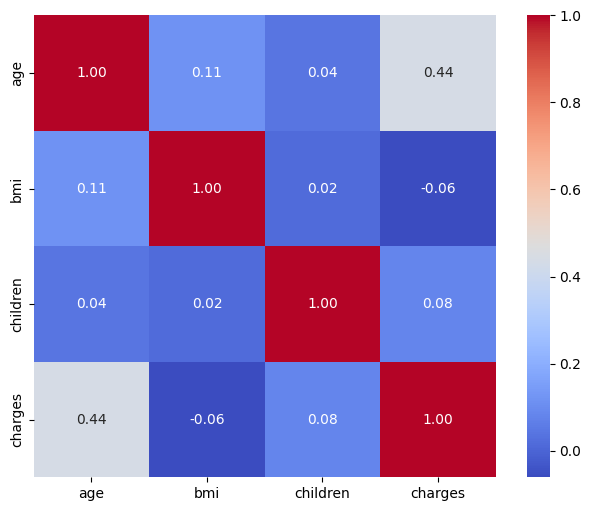

In [318]:
correlation_matrix = df[['age', 'bmi', 'children', 'charges']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.show()

## Observation

We've observed this before as well that age is positivley and strongly correlated to charges. BMI is negatively correlated to charges with least magnitude. Thus, we will remove BMI from our predictor features and evaluate our model.

In [319]:
X = normalized_df_encoded.drop(['charges','bmi'], axis=1)
y = normalized_df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients of the model
coefficients_df = pd.DataFrame({'Predictor': X_train.columns, 'Coefficient': model.coef_})
print('\nCoefficients:')
print(coefficients_df)

# Intercept of the model
print(f'\nIntercept: {model.intercept_}')


Coefficients:
    Predictor   Coefficient
0         age  11344.859673
1    children   2157.073503
2  smoker_yes  15290.426293

Intercept: 2594.851265201415


## Interpreation

1. We see similar trend in the coefficent values.
2. Smoker_yes is the strongest feature followed by age. Children has a relatively lower impact.


In [321]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 18271926.30138263
Mean Absolute Error (MAE): 2628.822232650738
R-squared (R²): 0.617844882781343
Root Mean Squared Error (RMSE): 4274.567381780597


## Evaluation

There is not much impact on the evaluation metrics. The error metrics have slightly increased and the R² value has slightly decreased. This makes sense as we knew bmi had a very low correlation.

## Linear Regression with 2 strongest features

From the previous iterations, we can tell that smoker_yes and age features are the strongest in predicting the charges.

In [322]:
X = normalized_df_encoded.drop(['charges','bmi', 'children'], axis=1)
y = normalized_df_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients of the model
coefficients_df = pd.DataFrame({'Predictor': X_train.columns, 'Coefficient': model.coef_})
print('\nCoefficients:')
print(coefficients_df)

# Intercept of the model
print(f'\nIntercept: {model.intercept_}')


Coefficients:
    Predictor   Coefficient
0         age  11409.843604
1  smoker_yes  15236.636863

Intercept: 3033.282196796996


## Interpretation

There is a slight change in the coefficient and intercept values. The smoker_yes has decreased a little in magnitude whereas age has increased a little. Intercept value has increased a little bit.

In [323]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 18339666.15898912
Mean Absolute Error (MAE): 2637.5368956265397
R-squared (R²): 0.616428111894848
Root Mean Squared Error (RMSE): 4282.483643750332


## Evaluation

Again, there is very little changes in the evaluation metrics. The error metrics have slightly increased and the R² value has slightly decreased. This also makes sense as we know bmi and children had very low correlation and thus not a significant impact in the predictions.

## Heat Map

We will show the heat map of the variable predicted (charges) on the strongest 2 variables (smoker_yes & age)

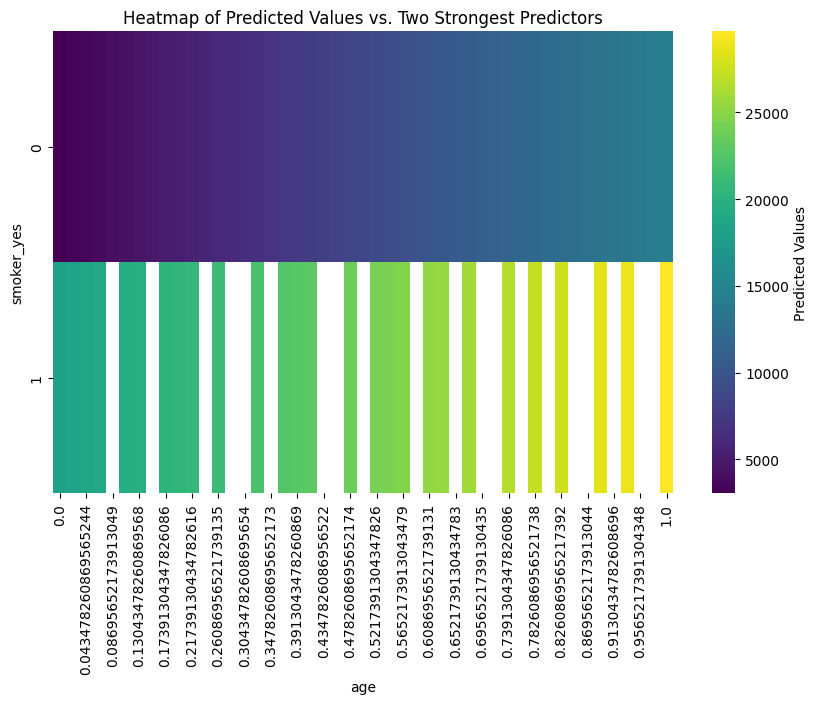

In [334]:
# Creating a DataFrame with the actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

X_test

# Creating a heatmap
plt.figure(figsize=(10, 6))
heatmap_data = pd.concat([results_df, X_test], axis=1)
heatmap_data = heatmap_data.groupby(['smoker_yes', 'age']).mean().reset_index()
heatmap_data_pivoted = heatmap_data.pivot(index='smoker_yes', columns='age', values='Predicted')
sns.heatmap(heatmap_data_pivoted, cmap='viridis', annot=False, fmt=".2f", cbar_kws={'label': 'Predicted Values'})
plt.title('Heatmap of Predicted Values vs. Two Strongest Predictors')
plt.show()

## Interpretation of HeatMap

1. The heat map shows a clear pattern that as age increases, the charges increase.
2. Non smoker have lower charges than the smokers.
3. The lowest charges for smokers in the lower age range is still higher than the highest charges for non-smoker in the higher age range.
4. The presence of clear pattern indicates that the model is capturing meaningful patterns in data.

# Conclusion

1. Members who are smokers have charges greater than the median of charges. Smoker feature has the strongest effect on charges.
2. As age increases, the charges increase as well. Age is a very strong predictor as well but slightly less effect than smoker predictor variable.
3. Number of children a member has, the bmi of a member, the region a member belongs and the gender of a member don't have much impact on the charges.
4. For this dataset and our LinearRegression model, normalization and standardization had same exact evaluation results.
5. The evaluation metrics of the model increases slightly if variables other than the strongest 2 (smoker_yes & age) are added to the features.

